In [10]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse

import numpy as np
import torch
# from visualizer import get_local
# get_local.activate()
from playground import build_all_model
import datasets.transforms as T
from PIL import Image
import cv2

import math
import requests
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from torch import nn
torch.set_grad_enabled(False);


def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr_backbone', default=1e-4, type=float)
    parser.add_argument('--weight_decay', default=0.05, type=float)
    parser.add_argument('--batch_size', default=1, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Pix2Seq
    parser.add_argument('--model', type=str, default="pix2seq",
                        help="specify the model from playground")
    parser.add_argument('--pix2seq_lr', action='store_true', help='use warmup linear drop lr')
    parser.add_argument('--large_scale_jitter', action='store_true', help='large scale jitter')
    parser.add_argument('--rand_target', action='store_true',
                        help="randomly permute the sequence of input targets")
    parser.add_argument('--pred_eos', action='store_true', help='use eos token instead of predicting 100 objects')

    # * Backbone
    parser.add_argument('--backbone', default='swin_L', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=1024, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--pre_norm', action='store_true')

    # * Loss coefficients
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset_file', default='coco')
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--device', default='cpu',
                        help='device to use for training / testing')
    # parser.add_argument('--resume', default='./output/dota_v6/checkpoint_best.pth', help='resume from checkpoint')
    parser.add_argument('--resume', default='./output/HRSC_4cls_v5/checkpoint_best.pth', help='resume from checkpoint')
    parser.add_argument('--num_workers', default=2, type=int)

    parser.add_argument('--num_classes', default=4, type=int, help='max ID of the datasets')

    parser.add_argument('--img_path', default='./HRSC/Test/AllImages/100000648.jpg', type=str, help='the path to predict')
    parser.add_argument('--swin_path', default='./weights/swin_large_patch4_window7_224_22k.pth', help='resume from swin transformer')
    parser.add_argument('--activation', default='relu', help='transformer activation function')
    parser.add_argument('--input_size', default=1333, type=int, help='max ID of the datasets')
    parser.add_argument('--need_attn', default=True, action='store_true',
                        help='if return the deformable attention weights, for visualization only')
    return parser


class Colors:
    # Ultralytics color palette https://ultralytics.com/
    def __init__(self):
        # hex = matplotlib.colors.TABLEAU_COLORS.values()
        hex = ('FF3838', 'FF9D97', 'FF701F', 'FFB21D', 'CFD231', '48F90A', '92CC17', '3DDB86', '1A9334', '00D4BB',
               '2C99A8', '00C2FF', '344593', '6473FF', '0018EC', '8438FF', '520085', 'CB38FF', 'FF95C8', 'FF37C7')
        self.palette = [self.hex2rgb('#' + c) for c in hex]
        self.n = len(self.palette)

    def __call__(self, i, bgr=False):
        c = self.palette[int(i) % self.n]
        return (c[2], c[1], c[0]) if bgr else c

    @staticmethod
    def hex2rgb(h):  # rgb order (PIL)
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))


def plot_one_box(x, im, color=(128, 128, 128), label=None, line_thickness=3):
    # Plots one bounding box on image 'im' using OpenCV
    assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to plot_on_box() input image.'
    tl = line_thickness or round(0.002 * (im.shape[0] + im.shape[1]) / 2) + 1  # line/font thickness
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(im, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(im, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)


def plot_one_box_polyl(x, im, color=(128, 128, 128), label=None, line_thickness=3):
    # Plots one bounding box on image 'im' using OpenCV
    assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to plot_on_box() input image.'
    tl = line_thickness or round(0.002 * (im.shape[0] + im.shape[1]) / 2) + 1  # line/font thickness
    points = np.array(x).reshape(4, 2).reshape(4, 1, 2).astype(int)
    # c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    # cv2.rectangle(im, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    cv2.polylines(im, [points], True, color, line_thickness)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        # c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        # cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(im, label, (int(x[0]), int(x[1]) - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)


def plot_results(pil_img, prob, boxes, CLASSES, COLORS):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


def isfakebox(box, h_ori, w_ori):
    border_flag = 0
    for p in box:
        if abs(int(p) - 1333) < 20 or int(p) < 20 or abs(int(p) - h_ori) < 20 or abs(int(p) - w_ori) < 20 :
            border_flag += 1
    if border_flag == 8:
        return True
    else:
        return False


def PostProcess(args, image_path, output, names, h_ori, w_ori, h, w):
    out_seq_logits = output['pred_seq_logits']

    orig_size = torch.as_tensor([int(h_ori), int(w_ori)])
    size = torch.as_tensor([int(h), int(w)])
    origin_img_sizes = torch.stack([orig_size], dim=0)
    input_img_sizes = torch.stack([size], dim=0)
    ori_img_h, ori_img_w = origin_img_sizes.unbind(1)
    inp_img_h, inp_img_w = input_img_sizes.unbind(1)
    num_bins = 2000
    num_classes = args.num_classes
    image = cv2.imread(image_path)
    scale_fct = torch.stack(
            [ori_img_w / inp_img_w, ori_img_h / inp_img_h,
             ori_img_w / inp_img_w, ori_img_h / inp_img_h,
             ori_img_w / inp_img_w, ori_img_h / inp_img_h,
             ori_img_w / inp_img_w, ori_img_h / inp_img_h], dim=1).unsqueeze(1).to(args.device)
    results = []
    for b_i, pred_seq_logits in enumerate(out_seq_logits):
        # print('pred_seq_logits'.format(pred_seq_logits))
        seq_len = pred_seq_logits.shape[0]
        if seq_len < 9:
            results.append(dict())
            continue
        pred_seq_logits = pred_seq_logits.softmax(dim=-1)
        num_objects = seq_len // 9
        pred_seq_logits = pred_seq_logits[:int(num_objects * 9)].reshape(num_objects, 9, -1)
        pred_boxes_logits = pred_seq_logits[:, :8, :num_bins + 1]
        pred_class_logits = pred_seq_logits[:, 8, num_bins + 1: num_bins + 1 + num_classes]
        # print(pred_class_logits)
        scores_per_image, labels_per_image = torch.max(pred_class_logits, dim=1)
        boxes_per_image = pred_boxes_logits.argmax(dim=2) * 1333 / num_bins
        boxes_per_image = boxes_per_image * scale_fct[b_i]
        result = dict()
        result['scores'] = []
        result['labels'] = []
        result['boxes'] = []
        idx = []
        index = 0
        for score, cls, box in zip(scores_per_image.detach().cpu().numpy(),
                                         labels_per_image.detach().cpu().numpy(),
                                         boxes_per_image.detach().cpu().numpy()):
            box = box.tolist()
            if score > 0.1 and not isfakebox(box, h_ori, w_ori):
                result['scores'].append(score)
                result['labels'].append(cls)
                result['boxes'].append(box)
                # print('box: ', box)
                colors = Colors()
                c = int(cls - 1)
                plot_one_box_polyl(box, image, label=names[c], color=colors(c, True), line_thickness=3)
                idx.append(index)
                index += 1
            else:
                index += 1
                break
        cv2.imwrite('./result.jpg', image)
        results.append(result)
    print(results)
    print(idx)
    return results

In [ ]:
parser = argparse.ArgumentParser('Pix2Seq training and evaluation script', parents=[get_args_parser()])
args = parser.parse_args(args=['--device', 'cpu'])
device = torch.device(args.device)
model_path = args.resume
model, _, _ = build_all_model[args.model](args)
checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)

model.to(device)
model.eval()

In [6]:
names = ['QHJ', 'XYJ', 'DLJ', 'YSJ', 'LGJ', 'HKMJ', 'ZHJ', 'QT', 'HC', 'KC', 'BZJ', 'YLC', 'ship']
names = ['ship', 'aircraft carrier', 'warcraft', 'merchant ship']
# names = ['plane']
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
#read image
image_path = './DOTA/train2017/P0167__1.0__1000___0.png'  # P2030__1.0__1000___1000.png
image_path = './HRSC/Test/AllImages/100000648.jpg' # 航母图片
image = Image.open(image_path)
image = image.convert('RGB')

w_ori, h_ori = image.size
print(image.size)

#transform
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform = T.Compose([
    # T.RandomResize([800], max_size=1333),
    normalize,
])

image_new = transform(image, None)

c,h,w = image_new[0].shape
print(c, h, w)
image_new = image_new[0].view(1, c, h, w).to(device)
seq = torch.ones(1, 1).to(device,dtype=torch.long) * 2001

(1193, 843)
3 843 1193


In [7]:

# use lists to store the outputs via up-values
swin_output, conv_features, enc_attn_weights, dec_self_weights, dec_attn_weights =[], [], [], [], []
mean = [0.485,0.456,0.406]
std = [0.229,0.224,0.225]
hooks = [
    model.backbone[0].body.norm3.register_forward_hook(
        lambda self, input, output: swin_output.append(output)
    ), # (1, h*w, 1536)
    model.backbone[0].input_proj3[1].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ), # (1, 256, h, w)
    model.transformer.encoder.layers[-1].ms_deformbale_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ), # attn: (1, h, w, 8, 4) offset: (1, h, w, 8, 8)
    model.transformer.decoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: dec_self_weights.append(output)
    ), # list(([1, 1, 256], [1, 1, h*w]), .....)
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output)
    ), # list(([1, 1, 256], [1, 1, h*w]), .....)
]

# propagate through the model
output = model([image_new, seq])

for hook in hooks:
    hook.remove()

# don't need the list anymore
swin_output = swin_output[0]
# cv2.imwrite('swin_output.jpg', (conv_features[0][0, 0, ...] * 255).reshape(26, 38, 1).numpy())
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights

print('swin_output features:', swin_output.shape)
print('enc_attn: ', enc_attn_weights['attns'].shape)
print('len(dec_attn)', len(dec_attn_weights))
print('dec_attn[0][0].shape:', dec_attn_weights[0][0].shape)
print('dec_attn[0][1].shape:', dec_attn_weights[0][1].shape)
_, attn_h , attn_w, _, _ = enc_attn_weights['attns'].shape

swin_output features: torch.Size([1, 1026, 1536])
enc_attn:  torch.Size([1, 27, 38, 8, 4])
len(dec_attn) 900
dec_attn[0][0].shape: torch.Size([1, 1, 256])
dec_attn[0][1].shape: torch.Size([1, 1, 1026])


In [11]:
results = PostProcess(args, image_path, output, names, h_ori, w_ori, h, w)
num_boxes = len(results[0]['scores'])
colors = Colors()

[{'scores': [0.99993324, 0.99988353, 0.9991756, 0.9987691], 'labels': [2, 3, 3, 3], 'boxes': [[878.447021484375, 767.8079833984375, 700.4915161132812, 757.1439819335938, 749.8125, 47.987998962402344, 929.7675170898438, 59.98500061035156], [630.5089721679688, 813.7965087890625, 587.1865234375, 811.1304931640625, 593.8515014648438, 517.8704833984375, 637.1740112304688, 519.8699951171875], [637.8405151367188, 391.9020080566406, 585.18701171875, 388.5694885253906, 607.1815185546875, 42.65599822998047, 658.5020141601562, 45.321998596191406], [237.9405059814453, 795.134521484375, 198.61700439453125, 791.802001953125, 214.61300659179688, 496.5425109863281, 256.6025085449219, 499.875]]}]
[0, 1, 2, 3]


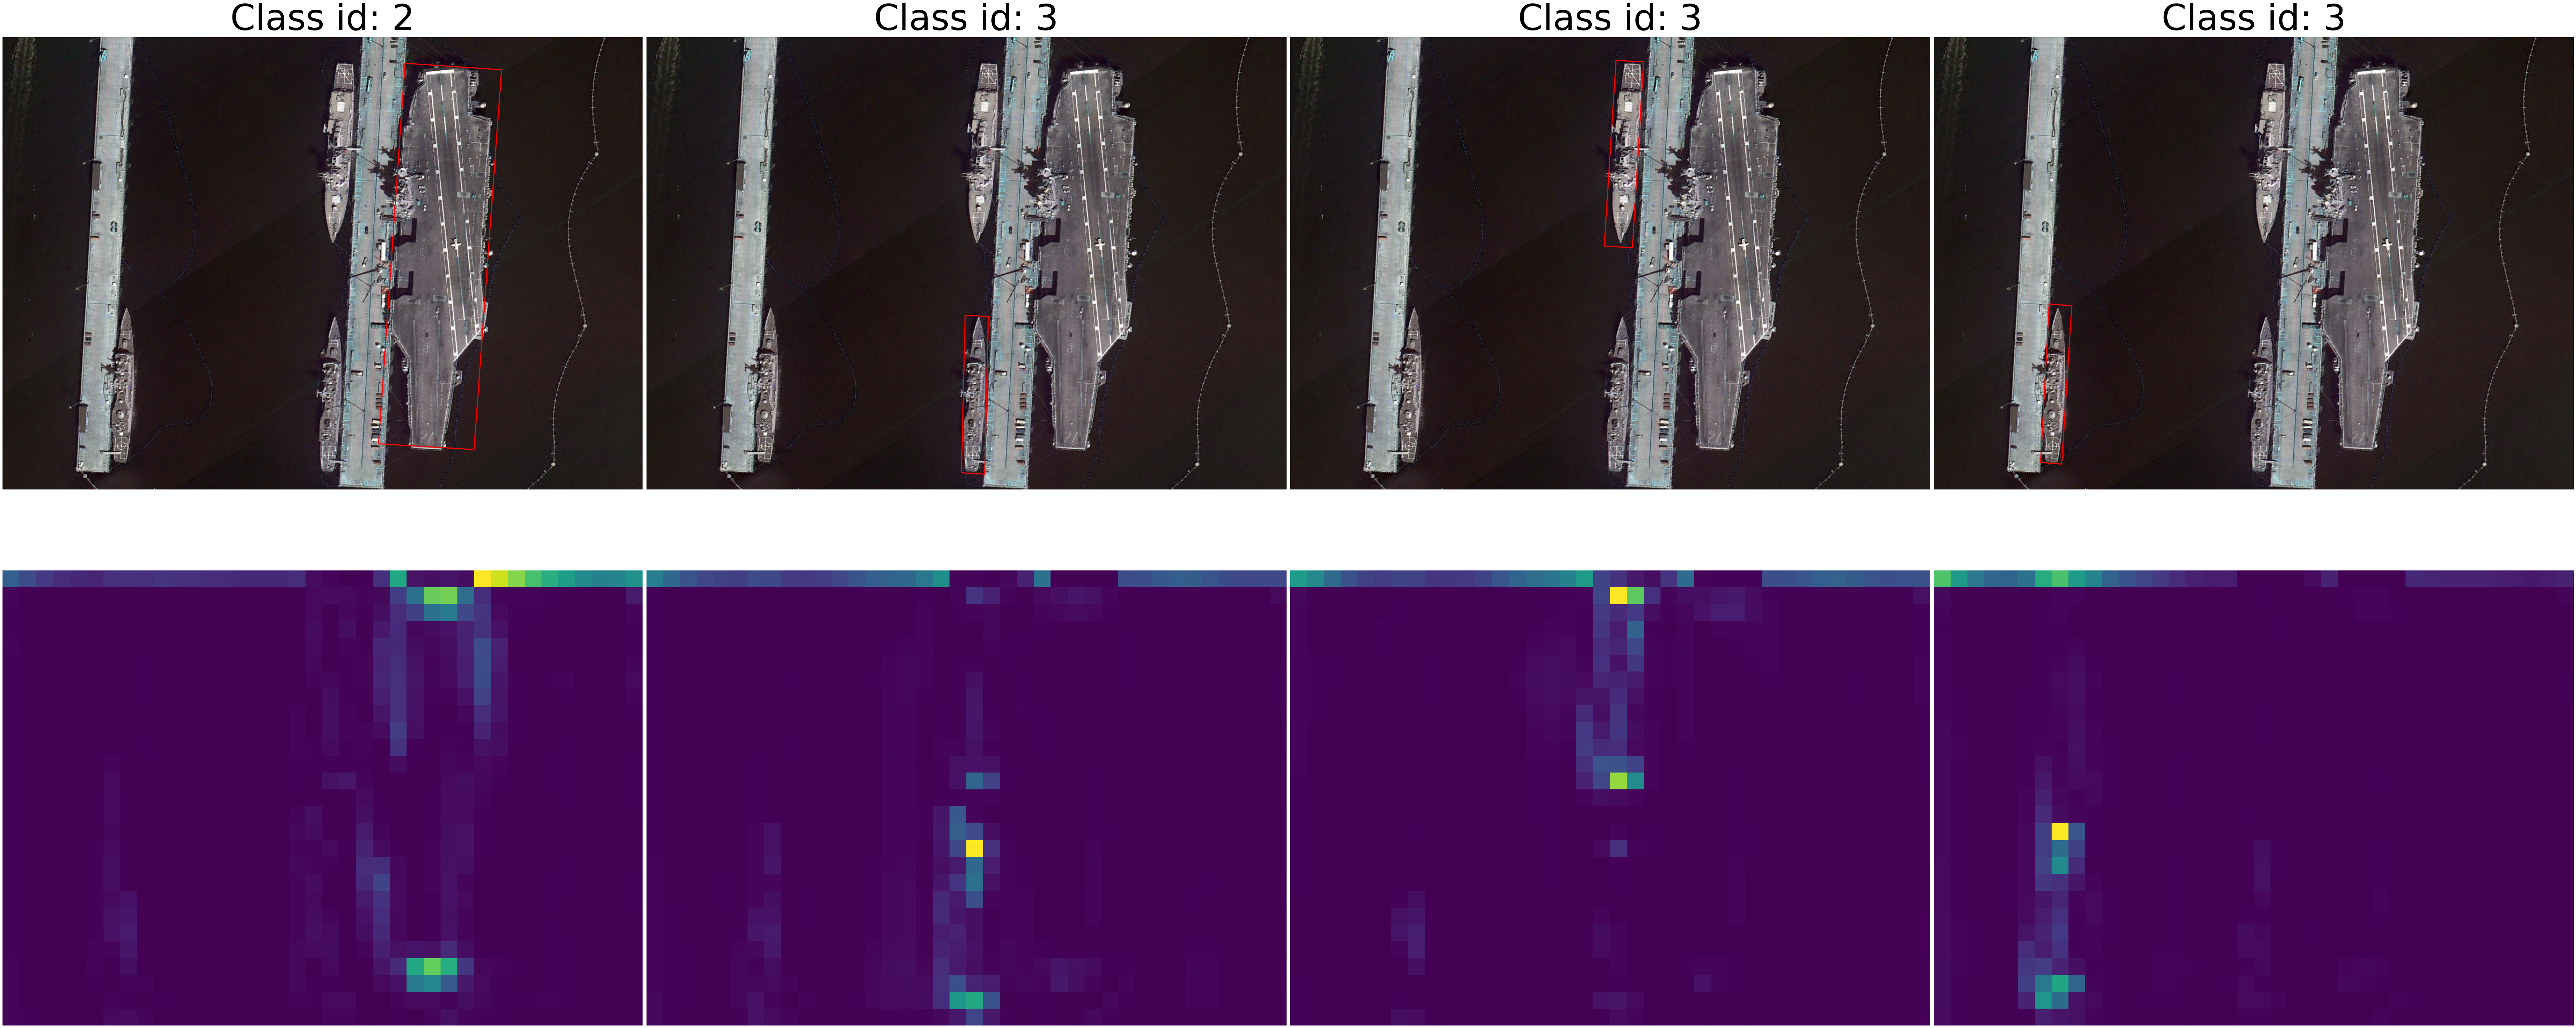

In [12]:
# decoder multihead attention weights 9points sum
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig, axs = plt.subplots(ncols=num_boxes, nrows=2, figsize=(100, 45))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
image_source = cv2.imread(image_path)
for idx, ax_i in zip(range(num_boxes), axs.T):
    ax = ax_i[0]
    image_copy = image_source.copy()
    box = results[0]['boxes'][idx]
    c = results[0]['labels'][idx]
    ax.imshow(image_copy)
    x = box[::2]
    y = box[1::2]
    points = list(zip(x,y))
    polygon= plt.Polygon(points,  fill=False, edgecolor='r', linewidth=3)
    ax.add_patch(polygon)
    ax.axis('off')
    ax.set_title(f'Class id: {c}', fontsize=100)
    dec_attn_weights_object = torch.zeros(attn_h, attn_w)
    for i in range(8):
        # ax = ax_i[i + 1]
        # ax.imshow(dec_attn_weights[idx*9 + i][1].reshape(26, 34))
        dec_attn_weights_object = dec_attn_weights[idx*9 + i][1].reshape(attn_h, attn_w) + dec_attn_weights_object
        # ax.axis('off')
    ax = ax_i[1]
    ax.imshow(dec_attn_weights_object)
    ax.axis('off')
fig.tight_layout()
plt.savefig('./visualize/dec_attn_sum.png')

In [ ]:
# decoder multihead attention weights 9points

fig, axs = plt.subplots(ncols=num_boxes, nrows=10, figsize=(110, 180))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
# for ax in axs:
#     ax.set_xlabel('Common x-label')
#     ax.set_ylabel('Common y-label')
# axs[-1, 0].set_ylabel('Y-Label', fontsize=80)
image_copy = image_source.copy()
image_source = cv2.imread(image_path)
for i, row in enumerate(axs):
    for j, col in enumerate(row):
        box = results[0]['boxes'][j]
        c = results[0]['labels'][j]
        if i == 0:
            col.imshow(image_copy)
            x = box[::2]
            y = box[1::2]
            points = list(zip(x, y))
            polygon = plt.Polygon(points, fill=False, edgecolor='r', linewidth=3)
            col.add_patch(polygon)
            # col.axis('off')
            col.set_title(f'Class id: {c}', fontsize=80)
            col.set_ylabel(f'Object{j}', fontsize=80)
        else:
            col.imshow(dec_attn_weights[j*9 + i - 1][1].reshape(attn_h, attn_w))
            # col.axis('off')
            col.set_ylabel('y-label', fontsize=80)
        
        
# for idx, ax_i in zip(range(num_boxes), axs.T):
#     ax = ax_i[0]
#     image_copy = image_source.copy()
#     box = results[0]['boxes'][idx]
#     c = results[0]['labels'][idx]
#     ax.imshow(image_copy)
#     x = box[::2]
#     y = box[1::2]
#     points = list(zip(x,y))
#     polygon = plt.Polygon(points, fill=False, edgecolor='r', linewidth=3)
#     ax.add_patch(polygon)
#     ax.axis('off')
#     ax.set_title(f'Class id: {c}', fontsize=80)
#     dec_attn_weights_object = torch.zeros(attn_h, attn_w)
#     for i in range(9):
#         ax = ax_i[i + 1]
#         # ax.set(ylabel="y-label")
#         # ax.set_ylabel("y-label", fontsize=80)
#         ax.imshow(dec_attn_weights[idx*9 + i][1].reshape(attn_h, attn_w))
#         ax.axis('off')
fig.tight_layout()
plt.savefig('./visualize/dec_attn.png')

In [ ]:
# decoder multihead attention weights 9points sum
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(100, 100))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
image_source = cv2.imread(image_path)
# for idx, ax_i in zip(range(num_boxes), axs.T):
ax_i = axs.T
ax = ax_i[0]
image_copy = image_source.copy()
box = results[0]['boxes'][idx]
c = results[0]['labels'][idx]
ax.imshow(image_copy)
# x = box[::2]
# y = box[1::2]
# points = list(zip(x,y))
# polygon= plt.Polygon(points,  fill=False, edgecolor='r', linewidth=3)
# ax.add_patch(polygon)
ax.axis('off')
ax.set_title(f'Class id: {c}', fontsize=100)

dec_attn_weights_new = []
for dec_attn in dec_attn_weights:
    dec_attn = dec_attn[1]
    dec_attn_weights_new.append(dec_attn)
dec_attn_weights_new = torch.stack(dec_attn_weights_new).sum(0).reshape(attn_h, attn_w)

ax = ax_i[1]
ax.imshow(dec_attn_weights_new)
ax.axis('off')
fig.tight_layout()
plt.savefig('./visualize/dec_attn_allsum.png')